In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [50]:
df = pd.read_csv('car_fuel_efficiency.csv')


In [51]:
df_col = ['engine_displacement','horsepower','vehicle_weight','model_year','fuel_efficiency_mpg']

df = df[df_col]

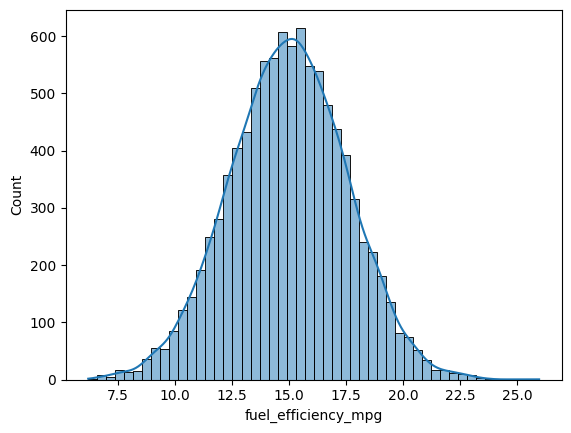

In [52]:
x = df['fuel_efficiency_mpg']
sns.histplot(x, bins=50, kde=True)
plt.show()

In [53]:
for i in df_col:
    if df[i].isna().sum() != 0:
        print(f"Missing values in {i}")

Missing values in horsepower


In [54]:

df['horsepower'].median()

np.float64(149.0)

In [55]:

shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(shuffled_df)

      engine_displacement  horsepower  vehicle_weight  model_year  \
0                     220       144.0     2535.887591        2009   
1                     160       141.0     2741.170484        2019   
2                     230       155.0     2471.880237        2017   
3                     150       206.0     3748.164469        2015   
4                     300       111.0     2135.716359        2006   
...                   ...         ...             ...         ...   
9699                  210       163.0     1972.029124        2011   
9700                  160       126.0     3011.588014        2009   
9701                  290       187.0     2440.508039        2019   
9702                  260       129.0     1865.404480        2019   
9703                  270       147.0     2611.939500        2017   

      fuel_efficiency_mpg  
0               16.642943  
1               16.298377  
2               18.591822  
3               11.818843  
4               19.402209  
...

In [70]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2

for d in (df_train, df_val, df_test):
    d.reset_index(drop=True, inplace=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val   = df_val.fuel_efficiency_mpg.values

X_train = df_train.drop(columns=['fuel_efficiency_mpg'])
X_val   = df_val.drop(columns=['fuel_efficiency_mpg'])

def train_linear_regression(X, y):
    X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    return w[0], w[1:]

def predict(X, w0, w):
    X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
    return X @ np.concatenate([[w0], w])

def rmse(y, y_pred):
    return np.sqrt(((y - y_pred) ** 2).mean())

In [72]:
X_train_0 = X_train.fillna(0).values
X_val_0   = X_val.fillna(0).values

hp_mean = X_train['horsepower'].mean()
X_train_m = X_train.fillna({'horsepower': hp_mean}).values
X_val_m   = X_val.fillna({'horsepower': hp_mean}).values

w0_0, w_0 = train_linear_regression(X_train_0, y_train)
rmse_0 = rmse(y_val, predict(X_val_0, w0_0, w_0))

w0_m, w_m = train_linear_regression(X_train_m, y_train)
rmse_m = rmse(y_val, predict(X_val_m, w0_m, w_m))

print("RMSE (fill 0):   ", round(rmse_0, 2))
print("RMSE (fill mean):", round(rmse_m, 2))
print("Better option", "With mean" if rmse_m < rmse_0 else "With 0")


RMSE (fill 0):    0.5
RMSE (fill mean): 0.46
Better option With mean


In [ ]:
def train_linear_regression_reg(X, y, r=0.0):
    X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
    XTX = X.T @ X
   
    reg = np.eye(XTX.shape[0]); reg[0, 0] = 0.0
    w_full = np.linalg.inv(XTX + r * reg) @ X.T @ y
    return w_full[0], w_full[1:]

X_train_reg = X_train.fillna(0).values
X_val_reg   = X_val.fillna(0).values

r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
scores = []

for r in r_values:
    w0, w = train_linear_regression_reg(X_train_reg, y_train, r=r)
    score = rmse(y_val, predict(X_val_reg, w0, w))
    scores.append((r, round(score, 2)))

for r, s in scores:
    print(f"r = {r:<6}  RMSE = {s:.2f}")

best = min(scores, key=lambda t: (t[1], t[0]))
print(f"\nBest r: {best[0]} with RMSE: {best[1]:.2f}")


r = 0       RMSE = 0.50
r = 0.01    RMSE = 0.50
r = 0.1     RMSE = 0.50
r = 1       RMSE = 0.50
r = 5       RMSE = 0.50
r = 10      RMSE = 0.50
r = 100     RMSE = 0.50

Best r: 0 with RMSE: 0.50


In [76]:
rmses = []
for seed in range(10):
    # Shuffle and split per seed (60/20/20)
    df_s = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    df_full_train_s, df_test_s = train_test_split(df_s, test_size=0.2, random_state=seed)
    df_train_s, df_val_s = train_test_split(df_full_train_s, test_size=0.25, random_state=seed)
    for d in (df_train_s, df_val_s):
        d.reset_index(drop=True, inplace=True)

    y_tr = df_train_s.fuel_efficiency_mpg.values
    y_va = df_val_s.fuel_efficiency_mpg.values
    X_tr = df_train_s.drop(columns=['fuel_efficiency_mpg']).fillna(0).values
    X_va = df_val_s.drop(columns=['fuel_efficiency_mpg']).fillna(0).values

    w0, w = train_linear_regression(X_tr, y_tr)
    rmses.append(rmse(y_va, predict(X_va, w0, w)))

print("Validation RMSEs by seed:", [round(s, 6) for s in rmses])
print("std:", round(np.std(rmses), 3))


Validation RMSEs by seed: [np.float64(0.523475), np.float64(0.524857), np.float64(0.518274), np.float64(0.532309), np.float64(0.515857), np.float64(0.514323), np.float64(0.514754), np.float64(0.520529), np.float64(0.521249), np.float64(0.521588)]
std: 0.005


In [77]:
# Split with seed=9
df9 = df.sample(frac=1, random_state=9).reset_index(drop=True)
df_full_train9, df_test9 = train_test_split(df9, test_size=0.2, random_state=9)
df_train9, df_val9 = train_test_split(df_full_train9, test_size=0.25, random_state=9)

# Combine train + val
df_full_train9 = pd.concat([df_train9, df_val9]).reset_index(drop=True)

# Prepare matrices
y_tr9 = df_full_train9.fuel_efficiency_mpg.values
y_te9 = df_test9.fuel_efficiency_mpg.values
X_tr9 = df_full_train9.drop(columns=['fuel_efficiency_mpg']).fillna(0).values
X_te9 = df_test9.drop(columns=['fuel_efficiency_mpg']).fillna(0).values

# Train ridge with r=0.001 (no bias reg)
w0, w = train_linear_regression_reg(X_tr9, y_tr9, r=0.001)
rmse_test = rmse(y_te9, predict(X_te9, w0, w))
print("Test RMSE (r=0.001):", round(rmse_test, 2))


Test RMSE (r=0.001): 0.53
